# Prepare Dataset

Load the "Titanic" data set from the file and display its summary.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv('data/titanic.csv')
df

,Survived,Pclass,Name,Sex,Age,Siblings and Spouses Aboard,Parents and Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


We will use the Survived column as a prediction target, and "Pclass", "Sex", "Age" and "Fare" columns as input features. Two of these features "Pclass" and "Sex" are categorical and the other two "Age" and "Fare" are numeric. Let's make a node of it since we will need it later.

In [2]:
numeric_features = ['Age', 'Fare']
categorical_features =  ['Pclass', 'Sex']
target = 'Survived'

Filter dataset by creating **X** and **y**, where **X** combines feature columns and **y** represents the target column. 

In [3]:

# In the documentation: 
# http://onnx.ai/sklearn-onnx/auto_examples/plot_intermediate_outputs.html
# we have the following recommendation: "scikit-learn does implicit conversions
#  when it can. sklearn-onnx does not. The ONNX version of OneHotEncoder must
# be applied on columns of the same type."
# TODO: we need to investigate it, but for now, let's follow the instruction
# for type conversion.
df['Pclass'] = df['Pclass'].astype(str)

X = df[numeric_features + categorical_features]
y = df[target]

print('X columns types:')
print('-'*20)
print(X.dtypes)

print()

print('y column type:')
print('-'*20)
print(y.dtypes)

X columns types:
--------------------
Age       float64
Fare      float64
Pclass     object
Sex        object
dtype: object

y column type:
--------------------
int64


# Train SKLearn Model

Define transformers for the numeric and categorical features. Then we wrap them into columns transformation objects. 

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# The numeric features preprocessing pipeline.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# The categorical features preprocessing pipeline.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# The data preprocessor combines numeric and categorical
# column transformers.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Define a Random Forest for the classifier for the prediction of surviving passengers.

In [5]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

Define an ML model which represented by the pipeline that combines a data preprocessor and classification algorithm.

In [6]:
model = Pipeline(steps=[
    ('precprocessor', preprocessor),
    ('classifier', classifier)
])

Split dataset on training and test.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Train a new model.

In [8]:
model.fit(X_train, y_train)
print('Model has been successfully trained')

Model has been successfully trained


Score the model using test data.

In [24]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
y_probas = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('The model accuracy: %.2f' % accuracy)

The model accuracy: 0.80


# Convert Model To ONNX

Define a function for converting Dataframe to ONNX schema.

In [10]:
from skl2onnx.common.data_types import Int64TensorType, FloatTensorType, StringTensorType

def convert_to_onnx_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = Int64TensorType([None, 1])
        elif v == 'float64':
            t = FloatTensorType([None, 1])
        else: # v == object
            t = StringTensorType([None, 1])
        inputs.append((k,t))
    return inputs

Convert and save the model into ONNX format.

In [11]:
from skl2onnx import convert_sklearn

initial_type = convert_to_onnx_schema(X)
print('The ONNX input schema:', initial_type)


onnx_filename = 'titanic.onnx'
onnx_model = convert_sklearn(model, initial_types=initial_type)
with open(onnx_filename, "wb") as f:
    f.write(onnx_model.SerializeToString())
    print('The model has been successfully saved in %s;' % onnx_filename)

The ONNX input schema: [('Age', FloatTensorType(shape=[None, 1])), ('Fare', FloatTensorType(shape=[None, 1])), ('Pclass', StringTensorType(shape=[None, 1])), ('Sex', StringTensorType(shape=[None, 1]))]
The model has been successfully saved in titanic.onnx;


Score ONNX model using the test data.

In [12]:
def convert_to_onnx_inputs(df):
    inputs = {c: df[c].values for c in df.columns}
    for c in numeric_features:
        inputs[c] = inputs[c].astype(np.float32)
    for k in inputs:
        inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))
    return inputs


In [20]:
import onnxruntime as rt

onnx_inputs = convert_to_onnx_inputs(X_test)

sess = rt.InferenceSession(onnx_filename)
y_onnx_pred, y_onnx_probas = sess.run(None, onnx_inputs)
onnx_accuracy = accuracy_score(y_test, y_onnx_pred)
print('The ONNX model accuracy: %.2f' % onnx_accuracy)

The ONNX model accuracy: 0.80


In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_onnx_pred)
cm

array([[198,   1],
       [  1,  93]])

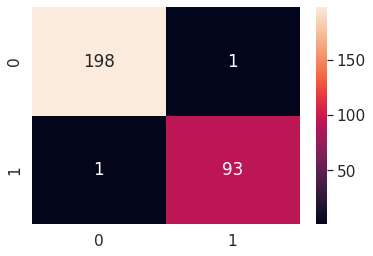

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True, fmt='d')

plt.show()

<AxesSubplot:>

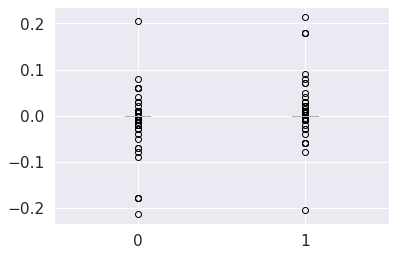

In [37]:
df_probas = pd.DataFrame(y_probas)
df_onnx_probas = pd.DataFrame(y_onnx_probas)

df_diff = df_probas - df_onnx_probas
df_diff.describe()
df_diff.boxplot()
